# Dog breed classification

This is the implementation on a ConvNet to identify the breed of a dog from an image of a dog. There are 120 breeds in total. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import seaborn as sns
import scipy.misc

from tensorflow.python.ops.image_ops import resize_image_with_crop_or_pad
from keras.preprocessing import image 
% matplotlib inline


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## Data exploration

In [2]:
# Turn the first image into a RGB array

img1 = mpimg.imread('datasets/train/257d7d5a3b94a225fa26aa537f6aa8d0.jpg')
print(img1.shape)

img2 = mpimg.imread('datasets/train/65345daeea5aff756587bbb685466ba6.jpg')
print(img2.shape)

img3 = mpimg.imread('datasets/train/a6827689ba680fa5d3ce835f62ed1b04.jpg')
print(img3.shape)

img4 = mpimg.imread('datasets/train/e68b9b319d716e7c3d927a823c99f6db.jpg')
print(img4.shape)

img5 = mpimg.imread('datasets/train/2585d3d8b52a90296e9b9917a9bfc81c.jpg')
print(img5.shape)

img6 = mpimg.imread('datasets/train/6549f5401c8c9888f9e6d812dc238aa2.jpg')
print(img6.shape)
# The images appear to be of different sizes - I will have to deal with this somehow.

(371, 500, 3)
(256, 354, 3)
(302, 500, 3)
(327, 300, 3)
(226, 300, 3)
(375, 500, 3)


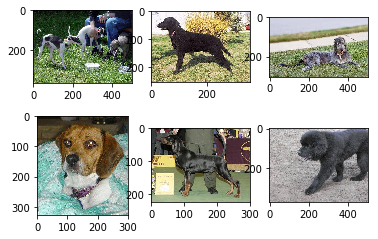

In [3]:

plt.subplot(231)
plt.imshow(img1)

plt.subplot(232)
plt.imshow(img2)

plt.subplot(233)
plt.imshow(img3)

plt.subplot(234)
plt.imshow(img4)

plt.subplot(235)
plt.imshow(img5)

plt.subplot(236)
plt.imshow(img6)

# There might also be more than one dog in the image - like in img1

In [4]:
# Exploratory analysis to figure out how to standardise the size of all the images

directory = 'datasets/train/'
img_list = []


for filename in os.listdir(directory):
    img_list.append(mpimg.imread(os.path.join(directory, filename)))
    
heights = [i.shape[0] for i in img_list]
widths = [i.shape[1] for i in img_list]


print("The number of images: %d" % len(img_list))
print("")
print("The Average height is: %f" % np.mean(heights))
print("The Std dev height is: %f" % np.std(heights))
print("The Max height is: %f" % np.amax(heights))
print("")
print("The Average width is: %f" % np.mean(widths))
print("The Std dev width is: %f" % np.std(widths))
print("The Max width is: %f" % np.amax(widths))

The number of images: 10222

The Average height is: 386.747212
The Std dev height is: 130.061964
The Max height is: 2562.000000

The Average width is: 443.331540
The Std dev width is: 152.412664
The Max width is: 3264.000000


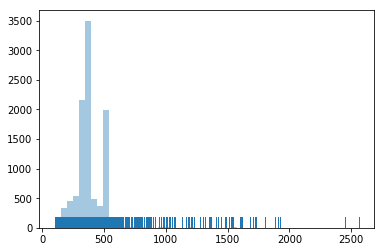

In [5]:
sns.distplot(np.array(heights), kde=False, rug=True);

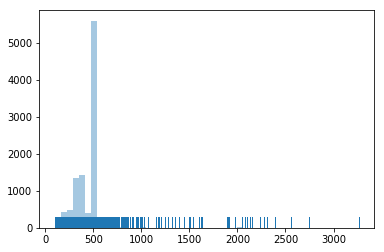

In [6]:
sns.distplot(np.array(widths), kde=False, rug=True);

Plotting the distributions of the heights and widths has revealed that both distributions are highly skewed i.e there are some very large images but most images seem to have heights and widths of less than about 550 pixels. Therefore, I think it may be wise to resize all images to the size (550, 550, 3). However, before I go ahead and resize these images, I want take a look at the test set and see if the image sizes follow a similar distribution.

In [7]:
directory = 'datasets/test/'
test_list = []


for filename in os.listdir(directory):
    test_list.append(mpimg.imread(os.path.join(directory, filename)))
    
t_heights = [i.shape[0] for i in test_list]
t_widths = [i.shape[1] for i in test_list]


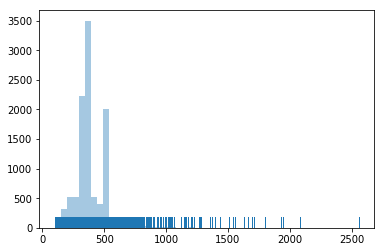

In [8]:
sns.distplot(np.array(t_heights), kde=False, rug=True);

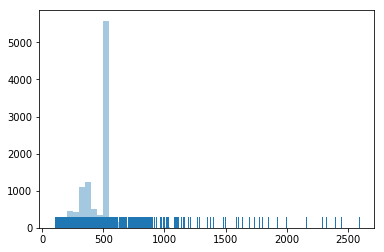

In [9]:
sns.distplot(np.array(t_widths), kde=False, rug=True);

The height and width test distributions are very similar to those of the training set. So similar in fact that I think it might be a good idea to take a look at some images. I hope the train and test set are not identical !

The size of the test set is: 10357


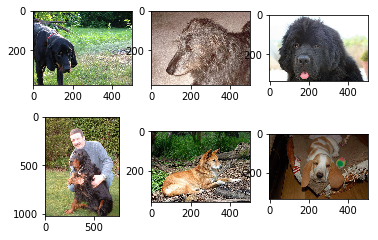

In [10]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(test_list[i])

print("The size of the test set is: %d" % len(test_list))

Funny - the test set is larger than the training set. Train set size = 10222 , and test set size = 10357 . How about my labels ? How many of those do I have ?

In [8]:
labels = pd.read_csv('datasets/labels.csv')

print(labels.shape)
labels.head()

(10222, 2)


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

Ok so as expected the labels correspond to the trainin set. However, it looks like I will have to perform a join at some point so that the images and labels are matched.

In [12]:
# Lets check how many images of each breed there are in the training set

labels.breed.value_counts()

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
pomeranian                        111
great_pyrenees                    111
basenji                           110
samoyed                           109
tibetan_terrier                   107
airedale                          107
leonberg                          106
cairn                             106
japanese_spaniel                  105
beagle                            105
australian_terrier                102
blenheim_spaniel                  102
miniature_pinscher                102
irish_wolfhound                   101
lakeland_terrier                   99
saluki                             99
papillon                           96
siberian_husky                     95
whippet                            95
norwegian_elkhound                 95
pug         

In [13]:
pd.isnull(labels.breed).value_counts()

# Ok so no null values in the labels

False    10222
Name: breed, dtype: int64

The last bit of my data exploration will be to have a quick look at the sample submission file for this Kaggle competition

In [ ]:
submission = pd.read_csv('datasets/sample_submission.csv')

submission.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1  00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2  0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3  001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4  001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.008333  0.008333                        0.008333     0.008333   
1             0.008333  0.008333                        0.008333     0.008333   
2             0.008333  0.008333                        0.008333     0.008333   
3             0.008333  0.008333                        0.008333     0.008333   
4             0.008333  0.008333                        0.008333     0.008333   

   australian_terrier   basenji    basset        ...          toy_poodle  \
0            0.008333  0.008333  0.008333        ...            0.008333   
1            0.008333  0.008333  0.008333        ...            0.008333   
2            0.008333  0.008333  0.008333        ...            0.008333   
3            0.008333  0.008333  0.008333        ...            0.008333   
4            0.008333  0.008333  0.008333        ...            0.008333   

   toy_terrier    vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0     0.008333  0.008333      0.008333    0.008333                0.008333   
1     0.008333  0.008333      0.008333    0.008333                0.008333   
2     0.008333  0.008333      0.008333    0.008333                0.008333   
3     0.008333  0.008333      0.008333    0.008333                0.008333   
4     0.008333  0.008333      0.008333    0.008333                0.008333   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.008333  0.008333                 0.008333   
1                     0.008333  0.008333                 0.008333   
2                     0.008333  0.008333                 0.008333   
3                     0.008333  0.008333                 0.008333   
4                     0.008333  0.008333                 0.008333   

   yorkshire_terrier  
0           0.008333  
1           0.008333  
2           0.008333  
3           0.008333  
4           0.008333  

[5 rows x 121 columns]

Looks like the expectation is that the output should contain the probability of the image being each of the 120 breeds - rather than a simple 1 or 0. 

## Feature Engineering and preparation of the datasets

1. Make all images (550,550,3)
2. Create training dataset of images and corresponsing labels in correct order
3. Create training set with 10,000 images and dev set with 222 images (roughly 98% : 2% )

### Make all images the same size

In [2]:
train_directory = 'datasets/train/'
train_img_dict = {}

for filename in os.listdir(train_directory):
    img = image.load_img(os.path.join(train_directory, filename), target_size=(550,550)) 
    img = image.img_to_array(img)
    train_img_dict[filename.split(".")[0]] = img
    
print(len(train_img_dict))


10222


In [5]:
# This only needed to be run once !

#for k in train_img_dict:
#    rgb = scipy.misc.toimage(train_img_dict[k])
#    mpl.image.imsave('datasets/train_aug/'+ k + '.jpg', rgb)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


I put all the augmented images into a folder called train_aug so I dont need to run this code again. I will deal with the test set at a later time. Now I will create a numpy array with dimensions (m, h, w, c) = (10222, 550, 550, 3). 

### Create numpy array with all images from train_aug folder

In [10]:
all_data = np.empty([10222, 550, 550, 3])

for index, row in labels.iterrows():
    img_id = row['id']
    all_data[index, :, :, :] = train_img_dict[img_id]
    
all_data.shape


(10222, 550, 550, 3)

### Construct the training and dev sets 

In [13]:
all_Y = pd.get_dummies(labels.breed)

all_Y.shape

(10222, 120)

In [20]:
# Note that plain bracket indexing works for Numpy array, but iloc is needed for a Pandas dataframe

X_train = all_data[0:10000, :, :, :]
Y_train = all_Y.iloc[0:10000, :]

X_dev = all_data[10000:, :, :, :]
Y_dev = all_Y.iloc[10000:, :]

print("The size of X_train %s" % (X_train.shape,))
print("The size of Y_train %s" % (Y_train.shape,))
print("The size of X_dev %s" % (X_dev.shape,))
print("The size of Y_dev %s" % (Y_dev.shape,))

The size of X_train (10000, 550, 550, 3)
The size of Y_train (10000, 120)
The size of X_dev (222, 550, 550, 3)
The size of Y_dev (222, 120)


## Using Keras to experiment with CNN architectures